# Test Set

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [3]:
amazon = pd.read_csv('/home/eydu/Desktop/minibook/ml/amazon_data/raw_data_test.csv')
print(amazon.shape)

(91000, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      264540        182243  182244  B005OSC218   AJZXTZ3I9A84H   
1      146085        548350  548351  B004VLVD50  A39RNG8DUXG7ZM   
2      281714        539422  539423  B001BDDT8K  A2FRFAQCWZJT3Q   
3      280559        119141  119142  B001U0ON5M  A1YREIUL7VDQ0B   
4      236948        352256  352257  B000E63L8S  A3JKXNOLX2QRJ7   

                         ProfileName  HelpfulnessNumerator  \
0                             Jeromy                     1   
1                         W. Chapman                     4   
2        B. Davis "The Happy Hermit"                     1   
3   Jennifer U. Heston "ex-academic"                     0   
4  darlene conright "alaskan darlin"                     2   

   HelpfulnessDenominator  Score        Time                  Summary  \
0                       1      5  1316995200                 The Best   
1                       4      5  1331596800  Makes great dog bones !   
2    

### Feature extraction on natural language data

In [5]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [6]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
# hv = joblib.load('hv.pkl')
# X_hv = hv.transform(amazon.Text)
# print(X_hv.shape)


from sklearn.feature_extraction.text import HashingVectorizer

# look at the text tokenizer=LemmaTokenizer(), strip_accents=ascii,  stop_words={'english'}, 
hv0 = joblib.load('hv0.pkl')

X_hv0 = hv0.fit_transform(amazon.Text) # mw adds uid as token

amazon['ScoreX'] = amazon['Score'].apply(lambda x: str(x))  # converts to day of week
hv2 = joblib.load('hv2.pkl')
X_hv2 = hv2.fit_transform(amazon.ScoreX) # mw adds uid as token

X_hv = X_hv0
print(X_hv.shape)

/home/eydu/Desktop/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/eydu/Desktop/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/eydu/Desktop/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/eydu/Desktop/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21

(91000, 524288)


In [7]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [9]:
# features from Amazon.csv to add to feature set
# amazon['reviewLen'] = amazon['Text'].str.len()

# X_quant_features = amazon[["Score", "reviewLen"]]
X_quant_features = amazon[[]]
print(X_quant_features.head(10))
print(type(X_quant_features))

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [10]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr, X_hv2])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 655360)


### Create `X`, scaled matrix of features

In [11]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 655360)


### create `y`, vector of Labels

In [12]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [14]:
# MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle
svm = joblib.load('best.svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 6588, 'Neg': 84412, 'TP': 2286, 'TN': 83345, 'FP': 1067, 'FN': 4302, 'Accuracy': 0.94099999999999995, 'Precision': 0.68177751267521625, 'Recall': 0.34699453551912568, 'desc': 'svm'}


In [15]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('best.lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6588, 'Neg': 84412, 'TP': 2089, 'TN': 83875, 'FP': 537, 'FN': 4499, 'Accuracy': 0.94465934065934065, 'Precision': 0.7955064737242955, 'Recall': 0.31709168184578018, 'desc': 'lgs'}


In [16]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('best.nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6588, 'Neg': 84412, 'TP': 2155, 'TN': 81376, 'FP': 3036, 'FN': 4433, 'Accuracy': 0.91792307692307695, 'Precision': 0.41514159121556538, 'Recall': 0.32710989678202795, 'desc': 'nbs'}


In [17]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('best.rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 6588, 'Neg': 84412, 'TP': 2556, 'TN': 80361, 'FP': 4051, 'FN': 4032, 'Accuracy': 0.91117582417582421, 'Precision': 0.38686241864688964, 'Recall': 0.38797814207650272, 'desc': 'rdg'}


In [18]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('best.prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 6588, 'Neg': 84412, 'TP': 2321, 'TN': 83370, 'FP': 1042, 'FN': 4267, 'Accuracy': 0.94165934065934065, 'Precision': 0.69015759738328875, 'Recall': 0.35230722525804492, 'desc': 'prc'}


### ROC plot to compare performance of various models and fits

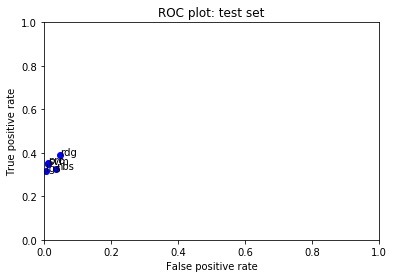

In [19]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()